
DETECTED COLUMNS:
Day                    --> Day
Time                   --> Time
Weather                --> Weather
Road_Conditions        --> Road Conditions
Lighting_Conditions    --> Lighting Conditions
Road_Type              --> Road Type
Types_of_turn          --> Types of turn being made
Vehicle_Manoeuvre      --> Vehicle Manoeuvre
Skidding               --> Skidding
Journey_purpose        --> Journey purpose of driver or rider
Impact                 --> Vehicle first point of impact
Alcohol                --> Alcohol breath test
Cas_Group              --> Casualty Vehicle group
Seat_belt              --> Seat belt used?
Casualty_severity      --> Casualty Severity
Num_Casualties         --> No. Casualties
Num_Vehicles           --> No. Vehicles
Severity_indicator     --> Collision Severity


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Day': 'C', 'Time_period': 'C', 'Weather': 'C', 'Road_Conditions': 'C', 'Lighting_Conditions': 'C', 'Road_Type': 'C', 'Types_of_turn_being_made': 'C', 'Vehicle_Manoeuvre': 'C', 'Vehicle_first_point_of_impact': 'C', 'Skidding': 'C', 'Journey_purpose': 'C', 'Alcohol_breath_test': 'C', 'Casualty_Vehicle_group': 'C', 'Seat_belt_used': 'C', 'Casualty_severity': 'C', 'Num_Casualties': 'C', 'Num_Vehicles': 'C', 'Severity_indicator': 'C', 'Congestion_Level': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Day': 'C', 'Time_period': 'C', 'Weather': 'C', 'Road_Conditions': 'C', 'Lighting_Conditions': 'C', 'Road_Type': 'C', 'Types_of_turn_being_made': 'C', 'Vehicle_Manoeuvre': 'C', 'Vehicle_first_point_of_impact': 'C', 'Skidding': 'C', 'Journey_purpose': 'C', 'Alcohol_breath_test': 'C', 'Casualty_Vehicle_group': 'C', 'Seat_belt_us


2-class edges used (30): [('Weather', 'Road_Conditions'), ('Weather', 'Skidding'), ('Road_Type', 'Vehicle_Manoeuvre'), ('Road_Type', 'Types_of_turn_being_made'), ('Road_Conditions', 'Vehicle_Manoeuvre'), ('Road_Conditions', 'Skidding'), ('Lighting_Conditions', 'Skidding'), ('Vehicle_Manoeuvre', 'Vehicle_first_point_of_impact'), ('Vehicle_Manoeuvre', 'Seat_belt_used'), ('Vehicle_Manoeuvre', 'Casualty_Vehicle_group'), ('Time_period', 'Journey_purpose'), ('Journey_purpose', 'Alcohol_breath_test'), ('Time_period', 'Alcohol_breath_test'), ('Alcohol_breath_test', 'Casualty_Vehicle_group'), ('Alcohol_breath_test', 'Vehicle_first_point_of_impact'), ('Alcohol_breath_test', 'Seat_belt_used'), ('Skidding', 'Casualty_Vehicle_group'), ('Skidding', 'Vehicle_first_point_of_impact'), ('Skidding', 'Seat_belt_used'), ('Day', 'Casualty_Vehicle_group'), ('Vehicle_Manoeuvre', 'Casualty_Vehicle_group'), ('Vehicle_Manoeuvre', 'Casualty_severity'), ('Seat_belt_used', 'Casualty_severity'), ('Vehicle_first_poi

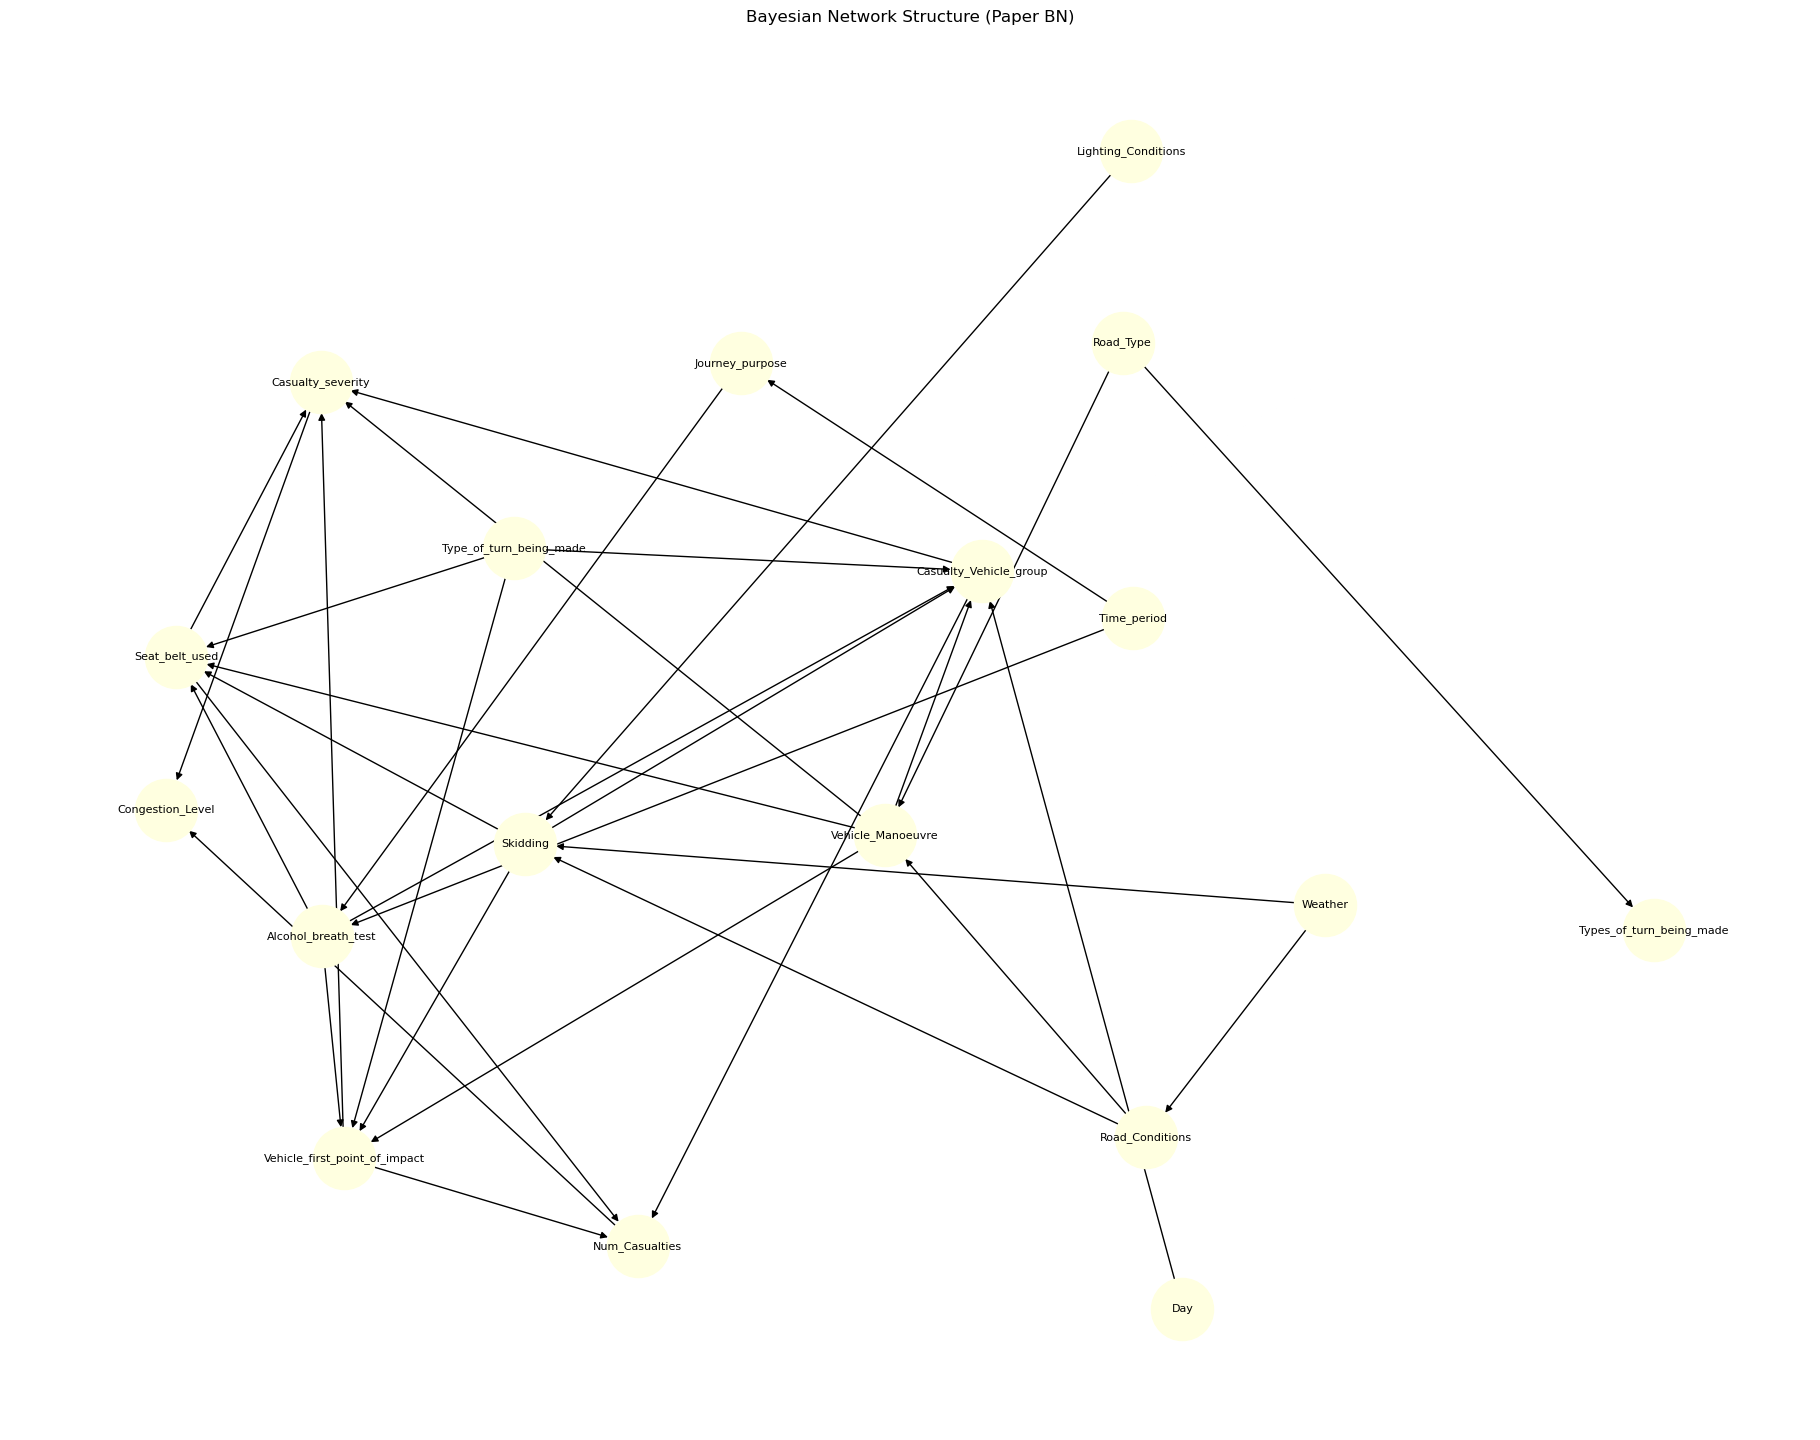

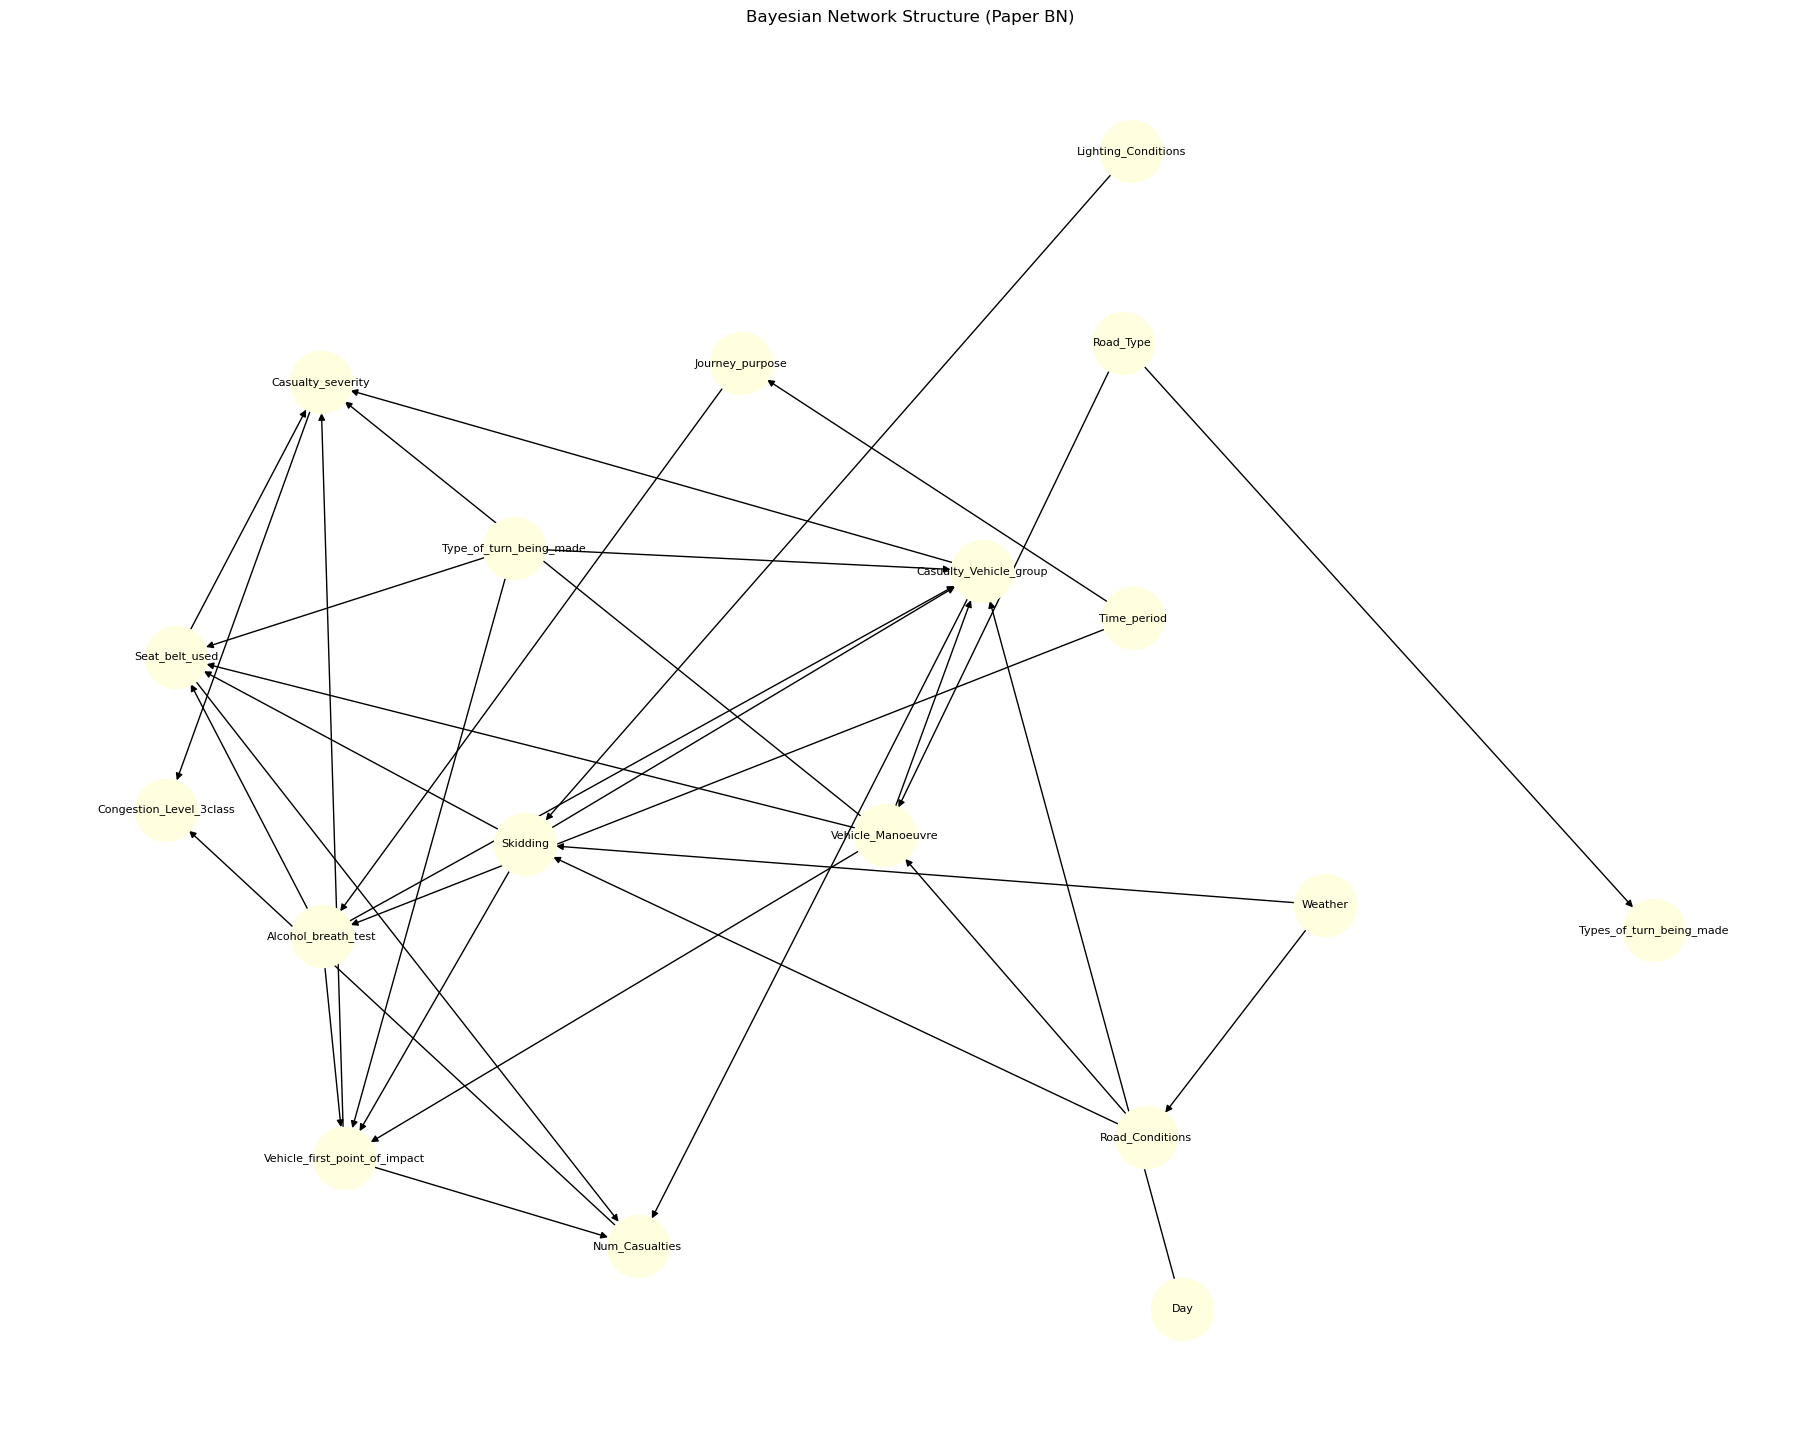

In [1]:
# FULL PIPELINE FOR 2-CLASS AND 3-CLASS BAYESIAN NETWORK
# Using Cambridgeshire Road Traffic Collision Dataset
# Exact Paper BN (with corrected missing link removal)

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
warnings.filterwarnings("ignore")

# Try pgmpy imports (different versions)
try:
    from pgmpy.models import DiscreteBayesianNetwork as DBN
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination
except:
    from pgmpy.models import BayesianModel as DBN
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination

# =======================
# HELPERS
# =======================

def find_column(cols, keywords):
    """Find column matching keyword."""
    if isinstance(keywords, str):
        keywords = [keywords]
    for kw in keywords:
        kw = kw.lower()
        for c in cols:
            if kw in c.lower():
                return c
    return None

def mode_or_first(series):
    try:
        m = series.mode()
        if len(m) > 0:
            return m.iloc[0]
        return series.iloc[0]
    except:
        return series.iloc[0]

def compress(series, min_count=80):
    vc = series.value_counts()
    keep = set(vc[vc >= min_count].index)
    return series.apply(lambda x: x if x in keep else "Others")

def time_to_period(t):
    try:
        if ":" in str(t):
            h = int(str(t).split(":")[0])
        else:
            h = int(float(str(t)))
    except:
        return "OFF Peak"
    if 7 <= h <= 10: return "AM Peak"
    if 16 <= h <= 19: return "PM Peak"
    return "OFF Peak"

def day_to_weekend(x):
    if pd.isna(x): return "Weekday"
    s = str(x).lower()
    if any(w in s for w in ["mon","tue","wed","thu","fri"]): return "Weekday"
    if any(w in s for w in ["sat","sun"]): return "Weekend"
    return "Weekday"

def bucket_count(x):
    try:
        v = int(float(x))
    except:
        return "0"
    if v == 0: return "0"
    if v == 1: return "1"
    if 2 <= v <= 3: return "2-3"
    if 4 <= v <= 6: return "4-6"
    return "7+"

def compute_cp(N, S_label, V):
    Smap = {"slight":1, "serious":2, "fatal":3}
    S = Smap.get(str(S_label).lower(), 1)
    try:
        N = float(N)
        V = float(V)
    except:
        N, V = 1.0, 30.0
    val = (2*(N + S*S) / np.sqrt(V+1)) * np.log10(N+1)
    return 5 + 95*np.tanh(val)

def classify_2class(cp):
    if cp < 50: return "Low"
    return "High"

def classify_3class(cp):
    if cp < 33.3: return "Low"
    if cp < 66.6: return "Medium"
    return "High"


# =======================
# LOAD DATA
# =======================
path = "/Users/Avchalam/Documents/s5/probability/project/Cambridgeshire-Road-Traffic-Collision-Data-1.xlsx"

cr = pd.read_excel(path, "Crashes")
veh = pd.read_excel(path, "Vehicles")
cas = pd.read_excel(path, "Casualties")

cr_cols = list(cr.columns)
veh_cols = list(veh.columns)
cas_cols = list(cas.columns)

# Detect collision ref key
key_cr = find_column(cr_cols, "collision")
key_veh = find_column(veh_cols, "collision")
key_cas = find_column(cas_cols, "collision")

join_key = "collision_id"
cr[join_key] = cr[key_cr]
veh[join_key] = veh[key_veh]
cas[join_key] = cas[key_cas]

# =======================
# DETECT REQUIRED COLUMNS
# =======================
colmap = {
    "Day": find_column(cr_cols, "day"),
    "Time": find_column(cr_cols, "time"),
    "Weather": find_column(cr_cols, "weather"),
    "Road_Conditions": find_column(cr_cols, "road conditions"),
    "Lighting_Conditions": find_column(cr_cols, "lighting"),
    "Road_Type": find_column(cr_cols, "road type"),
    "Types_of_turn": find_column(cr_cols+veh_cols, "turn"),
    "Vehicle_Manoeuvre": find_column(veh_cols, "manoeuvre"),
    "Skidding": find_column(veh_cols, "skidding"),
    "Journey_purpose": find_column(veh_cols, "journey"),
    "Impact": find_column(veh_cols, "impact"),
    "Alcohol": find_column(veh_cols, "alcohol"),
    "Cas_Group": find_column(cas_cols, "vehicle group"),
    "Seat_belt": find_column(cas_cols, "seat belt"),
    "Casualty_severity": find_column(cas_cols, "casualty severity"),
    "Num_Casualties": find_column(cr_cols, "casualties"),
    "Num_Vehicles": find_column(cr_cols, "vehicles"),
    "Severity_indicator": find_column(cr_cols, "collision severity"),
}

print("\nDETECTED COLUMNS:")
for k,v in colmap.items():
    print(f"{k:22s} --> {v}")


# =======================
# MERGING VEHICLES + CASUALTIES
# =======================
# Aggregate vehicle table
veh_vars = [join_key] + [colmap[c] for c in ["Vehicle_Manoeuvre","Skidding","Impact","Journey_purpose","Alcohol"] if colmap[c] is not None]
veh_agg = veh[veh_vars].groupby(join_key).agg(mode_or_first).reset_index()

# Aggregate casualty table
cas_vars = [join_key] + [colmap[c] for c in ["Cas_Group","Seat_belt","Casualty_severity"] if colmap[c] is not None]
cas_agg = cas[cas_vars].groupby(join_key).agg(mode_or_first).reset_index()

# Merge all
df = cr.merge(veh_agg, on=join_key, how="left")
df = df.merge(cas_agg, on=join_key, how="left")


# =======================
# RENAME TO PAPER NODE NAMES
# =======================
df_nodes = pd.DataFrame()
df_nodes["Day"] = df[colmap["Day"]].apply(day_to_weekend)
df_nodes["Time_period"] = df[colmap["Time"]].apply(time_to_period)
df_nodes["Weather"] = df[colmap["Weather"]].apply(lambda x: "Good" if "fine" in str(x).lower() else "Bad")
df_nodes["Road_Conditions"] = df[colmap["Road_Conditions"]].apply(lambda x: "Dry" if "dry" in str(x).lower() else "Wet")
df_nodes["Lighting_Conditions"] = df[colmap["Lighting_Conditions"]].apply(lambda x: "Daylight" if "day" in str(x).lower() else "Dark")
df_nodes["Road_Type"] = df[colmap["Road_Type"]].astype(str)
df_nodes["Types_of_turn_being_made"] = df[colmap["Types_of_turn"]].astype(str)

df_nodes["Vehicle_Manoeuvre"] = compress(df[colmap["Vehicle_Manoeuvre"]].astype(str))
df_nodes["Skidding"] = compress(df[colmap["Skidding"]].astype(str))
df_nodes["Journey_purpose"] = compress(df[colmap["Journey_purpose"]].astype(str))
df_nodes["Vehicle_first_point_of_impact"] = compress(df[colmap["Impact"]].astype(str))
df_nodes["Alcohol_breath_test"] = compress(df[colmap["Alcohol"]].astype(str))

df_nodes["Casualty_Vehicle_group"] = compress(df[colmap["Cas_Group"]].astype(str))
df_nodes["Seat_belt_used"] = compress(df[colmap["Seat_belt"]].astype(str))
df_nodes["Casualty_severity"] = df[colmap["Casualty_severity"]].astype(str)

df_nodes["Num_Casualties"] = df[colmap["Num_Casualties"]].apply(bucket_count)
df_nodes["Num_Vehicles"] = df[colmap["Num_Vehicles"]].apply(bucket_count)
df_nodes["Severity_indicator"] = df[colmap["Severity_indicator"]].astype(str)

# =======================
# COMPUTE CP + LABELS
# =======================
df_nodes["CP"] = df.apply(lambda r: compute_cp(
    bucket_count(r[colmap["Num_Vehicles"]]),
    r[colmap["Severity_indicator"]],
    bucket_count(r[colmap["Num_Vehicles"]])
), axis=1)

df_nodes["Congestion_Level"] = df_nodes["CP"].apply(classify_2class)
df_nodes["Congestion_Level_3class"] = df_nodes["CP"].apply(classify_3class)


# =======================
# FINAL BN DATASETS
# =======================
bn_cols_2 = [
    "Day","Time_period","Weather","Road_Conditions","Lighting_Conditions","Road_Type",
    "Types_of_turn_being_made","Vehicle_Manoeuvre","Vehicle_first_point_of_impact",
    "Skidding","Journey_purpose","Alcohol_breath_test","Casualty_Vehicle_group",
    "Seat_belt_used","Casualty_severity","Num_Casualties","Num_Vehicles",
    "Severity_indicator","Congestion_Level"
]

bn_cols_3 = bn_cols_2[:-1] + ["Congestion_Level_3class"]

df2 = df_nodes[bn_cols_2].dropna()
df3 = df_nodes[bn_cols_3].dropna()

train2, test2 = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2["Congestion_Level"])
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42, stratify=df3["Congestion_Level_3class"])

# =======================
# PAPER BN EDGES (FIXED VERSION)
# NO Casualty_severity → Num_Casualties
# =======================

# ======= FIXED: separate edge lists and robust fitting =======

# Define edges for 2-class model (uses Congestion_Level)
edges_2class = [
    ("Weather","Road_Conditions"),
    ("Weather","Skidding"),
    ("Road_Type","Vehicle_Manoeuvre"),
    ("Road_Type","Types_of_turn_being_made"),
    ("Road_Conditions","Vehicle_Manoeuvre"),
    ("Road_Conditions","Skidding"),
    ("Lighting_Conditions","Skidding"),
    ("Vehicle_Manoeuvre","Vehicle_first_point_of_impact"),
    ("Vehicle_Manoeuvre","Seat_belt_used"),
    ("Vehicle_Manoeuvre","Casualty_Vehicle_group"),
    ("Time_period","Journey_purpose"),
    ("Journey_purpose","Alcohol_breath_test"),
    ("Time_period","Alcohol_breath_test"),
    ("Alcohol_breath_test","Casualty_Vehicle_group"),
    ("Alcohol_breath_test","Vehicle_first_point_of_impact"),
    ("Alcohol_breath_test","Seat_belt_used"),
    ("Type_of_turn_being_made","Casualty_Vehicle_group"),
    ("Type_of_turn_being_made","Vehicle_first_point_of_impact"),
    ("Type_of_turn_being_made","Seat_belt_used"),
    ("Skidding","Casualty_Vehicle_group"),
    ("Skidding","Vehicle_first_point_of_impact"),
    ("Skidding","Seat_belt_used"),
    ("Day","Casualty_Vehicle_group"),
    ("Vehicle_Manoeuvre","Casualty_Vehicle_group"),
    ("Vehicle_Manoeuvre","Casualty_severity"),
    ("Seat_belt_used","Casualty_severity"),
    ("Vehicle_first_point_of_impact","Casualty_severity"),
    ("Vehicle_first_point_of_impact","Num_Casualties"),
    ("Seat_belt_used","Num_Casualties"),
    ("Casualty_Vehicle_group","Num_Casualties"),
    ("Casualty_Vehicle_group","Casualty_severity"),
    ("Casualty_severity","Congestion_Level"),
    ("Num_Casualties","Congestion_Level"),
]

# Define edges for 3-class model (uses Congestion_Level_3class)
edges_3class = [
    ("Weather","Road_Conditions"),
    ("Weather","Skidding"),
    ("Road_Type","Vehicle_Manoeuvre"),
    ("Road_Type","Types_of_turn_being_made"),
    ("Road_Conditions","Vehicle_Manoeuvre"),
    ("Road_Conditions","Skidding"),
    ("Lighting_Conditions","Skidding"),
    ("Vehicle_Manoeuvre","Vehicle_first_point_of_impact"),
    ("Vehicle_Manoeuvre","Seat_belt_used"),
    ("Vehicle_Manoeuvre","Casualty_Vehicle_group"),
    ("Time_period","Journey_purpose"),
    ("Journey_purpose","Alcohol_breath_test"),
    ("Time_period","Alcohol_breath_test"),
    ("Alcohol_breath_test","Casualty_Vehicle_group"),
    ("Alcohol_breath_test","Vehicle_first_point_of_impact"),
    ("Alcohol_breath_test","Seat_belt_used"),
    ("Type_of_turn_being_made","Casualty_Vehicle_group"),
    ("Type_of_turn_being_made","Vehicle_first_point_of_impact"),
    ("Type_of_turn_being_made","Seat_belt_used"),
    ("Skidding","Casualty_Vehicle_group"),
    ("Skidding","Vehicle_first_point_of_impact"),
    ("Skidding","Seat_belt_used"),
    ("Day","Casualty_Vehicle_group"),
    ("Vehicle_Manoeuvre","Casualty_Vehicle_group"),
    ("Vehicle_Manoeuvre","Casualty_severity"),
    ("Seat_belt_used","Casualty_severity"),
    ("Vehicle_first_point_of_impact","Casualty_severity"),
    ("Vehicle_first_point_of_impact","Num_Casualties"),
    ("Seat_belt_used","Num_Casualties"),
    ("Casualty_Vehicle_group","Num_Casualties"),
    ("Casualty_Vehicle_group","Casualty_severity"),
    ("Casualty_severity","Congestion_Level_3class"),
    ("Num_Casualties","Congestion_Level_3class"),
]

# Helper: filter edges to only include nodes present in a given DF
def filter_edges_for_df(edges, df_columns):
    filtered = [(u,v) for (u,v) in edges if (u in df_columns and v in df_columns)]
    missing_nodes = set([n for e in edges for n in e]) - set(df_columns)
    if missing_nodes:
        print("Warning: these nodes are missing from DF and edges referencing them will be removed:", missing_nodes)
    return filtered

# Filter edges for each train DF
edges_2class_filtered = filter_edges_for_df(edges_2class, train2.columns)
edges_3class_filtered = filter_edges_for_df(edges_3class, train3.columns)

print("\n2-class edges used ({}):".format(len(edges_2class_filtered)), edges_2class_filtered)
print("\n3-class edges used ({}):".format(len(edges_3class_filtered)), edges_3class_filtered)

# Now build and fit models, with checks
from pgmpy.base import DAG  # for node list access if needed

# Fit 2-class model
model2 = DBN(edges_2class_filtered)
try:
    model2.fit(train2, estimator=MaximumLikelihoodEstimator)
    infer2 = VariableElimination(model2)
    print("\n2-class model fitted successfully.")
except Exception as e:
    print("\nError fitting 2-class model:", e)
    # Debug helpful output
    print("train2 columns:", list(train2.columns))
    raise

# Fit 3-class model
model3 = DBN(edges_3class_filtered)
try:
    model3.fit(train3, estimator=MaximumLikelihoodEstimator)
    infer3 = VariableElimination(model3)
    print("\n3-class model fitted successfully.")
except Exception as e:
    print("\nError fitting 3-class model:", e)
    print("train3 columns:", list(train3.columns))
    raise

# Quick sanity: print nodes and parents for each model
print("\nModel2 nodes and parents:")
for n in model2.nodes():
    print(n, "parents->", model2.get_parents(n))

print("\nModel3 nodes and parents:")
for n in model3.nodes():
    print(n, "parents->", model3.get_parents(n))


# =======================
# PREDICT FUNCTIONS
# =======================
def predict2(row):
    ev = {k: row[k] for k in row.index if k != "Congestion_Level" and k in model2.nodes()}
    try:
        q = infer2.query(["Congestion_Level"], evidence=ev)
        states = q.state_names["Congestion_Level"]
        return states[np.argmax(q.values)]
    except:
        return train2["Congestion_Level"].mode().iloc[0]

def predict3(row):
    ev = {k: row[k] for k in row.index if k != "Congestion_Level_3class" and k in model3.nodes()}
    try:
        q = infer3.query(["Congestion_Level_3class"], evidence=ev)
        states = q.state_names["Congestion_Level_3class"]
        return states[np.argmax(q.values)]
    except:
        return train3["Congestion_Level_3class"].mode().iloc[0]

# =======================
# EVALUATION
# =======================
y2_true = test2["Congestion_Level"].tolist()
y2_pred = [predict2(r) for _,r in test2.iterrows()]

y3_true = test3["Congestion_Level_3class"].tolist()
y3_pred = [predict3(r) for _,r in test3.iterrows()]

print("\n===== 2-CLASS MODEL RESULTS =====")
print("Accuracy:", accuracy_score(y2_true, y2_pred))
print(classification_report(y2_true, y2_pred))

print("\n===== 3-CLASS MODEL RESULTS =====")
print("Accuracy:", accuracy_score(y3_true, y3_pred))
print("Macro F1:", f1_score(y3_true, y3_pred, average="macro"))
print(classification_report(y3_true, y3_pred))

# =======================
# PLOT BN (simple NX)
# =======================
G = nx.DiGraph()
G.add_edges_from(edges_2class)
plt.figure(figsize=(18,14))
pos = nx.spring_layout(G, seed=0, k=1.3)
nx.draw(G, pos, with_labels=True, node_color="lightyellow", node_size=2000, font_size=8)
plt.title("Bayesian Network Structure (Paper BN)")
plt.show()

G = nx.DiGraph()
G.add_edges_from(edges_3class)
plt.figure(figsize=(18,14))
pos = nx.spring_layout(G, seed=0, k=1.3)
nx.draw(G, pos, with_labels=True, node_color="lightyellow", node_size=2000, font_size=8)
plt.title("Bayesian Network Structure (Paper BN)")
plt.show()



In [2]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import to_pydot

def draw_bn_png(model, filename="bn_graph.png"):
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())
    pydot_graph = to_pydot(G)
    pydot_graph.write_png(filename)
    print(f"Saved graph to {filename}")

draw_bn_png(model2)


Saved graph to bn_graph.png


In [3]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import to_pydot

def draw_bn_png(model, filename="bn3_graph.png"):
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())
    pydot_graph = to_pydot(G)
    pydot_graph.write_png(filename)
    print(f"Saved graph to {filename}")

draw_bn_png(model3)


Saved graph to bn3_graph.png


In [4]:
evidence = {
    "Casualty_severity": "Serious",
    "Num_Casualties": "2-3",
    "Alcohol_breath_test": "Negative"
}
result = infer2.query(["Congestion_Level"], evidence=evidence)

print(result)
print("States:", result.state_names["Congestion_Level"])
print("Probabilities:", result.values)



+------------------------+-------------------------+
| Congestion_Level       |   phi(Congestion_Level) |
+========================+=========================+
| Congestion_Level(High) |                  1.0000 |
+------------------------+-------------------------+
| Congestion_Level(Low)  |                  0.0000 |
+------------------------+-------------------------+
States: ['High', 'Low']
Probabilities: [1. 0.]
